# Capao Urban Rate

This notebook aims to estimate the current urban growth rate for the place: Vale do Capão, Palmeiras, BA, Brasil. By using Google Earth satellite images and analyzing RGB pixel data, we can determine the growth rate in areas featuring houses, roads, construction sites, or where forests have been cleared for humans uses. For this case study, we have chosen COPERNICUS satellite images.

In [ ]:
import ee
import geemap as geemap
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt

from utils.contants import PROJECT
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics


ee.Authenticate()
ee.Initialize(project=PROJECT)
geemap.ee_initialize()

geo_point = ee.Geometry.Point([-41.501150593949305,-12.609558240448216])

image = (
  ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(geo_point)
    .filterDate('2023-01-01', '2023-12-01')
    .sort('CLOUDY_PIXEL_PERCENTAGE')
    .first()
)
# B2 - Blue | B3 - Green |  B4 - Red
bands = ['B2', 'B3', 'B4']

# Map view

In [ ]:
map = geemap.Map(center=[-12.609558240448216,-41.501150593949305], zoom=15)
# Adjust this value to increase or decrease the contrast
gamma = 3.5  
map.add_layer(
  image,  
  {"bands": bands,  min: 0, max: 2000, "gamma": gamma},
  "true colors"
)
# Display the map
map

# Pre processing

In [38]:
# df = pd.read_csv('./data/dataset_bands_3.csv')
df = pd.read_csv('./data/dataset_bands_6.csv')

# dataset = df[['system:index', 'B2', 'B3', 'B4']].copy()
dataset = df[['system:index', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']].copy()

dataset = dataset.replace(regex=r'1_\d+_\d+', value=0) # Urban Class 0
dataset = dataset.replace(regex=r'2_\d+_\d+', value=1) # Urban Class 1
dataset.rename(columns={'system:index': 'class'}, inplace=True)
dataset[110:130]


/tmp/ipykernel_72191/234733776.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset = dataset.replace(regex=r'2_\d+_\d+', value=1) # Urban Class 1


,class,B2,B3,B4,B5,B6,B7
110,0,745,1210,1590,1922,3184,3502
111,0,550,1032,1394,1525,3280,3836
112,0,621,1088,1508,1586,3061,3449
113,0,1160,1634,2504,2228,3436,3679
114,0,570,786,1068,1307,2606,3229
115,0,708,1104,804,1459,3104,3514
116,0,2974,3564,3600,2055,3332,3729
117,0,650,1050,1274,1478,3275,3784
118,0,1650,1926,2558,2655,3193,3336
119,0,941,1300,2144,2459,3239,3500


## Data Clusters

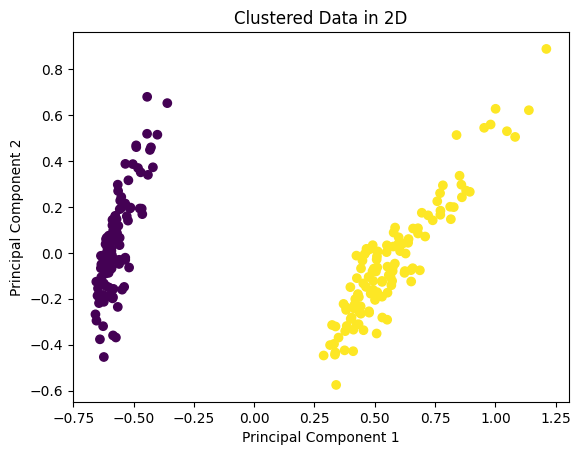

In [39]:
# Normalizing the data to be in the range (0, 1)
scaler = MinMaxScaler()
dataset_normalized = scaler.fit_transform(dataset)

# PCA to reduce dimensions from 3 to 2
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(dataset_normalized)

# K-means clustering
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(data_reduced)

# Visualize clusters
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=clusters, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data in 2D')
plt.show()

## Data Analysis

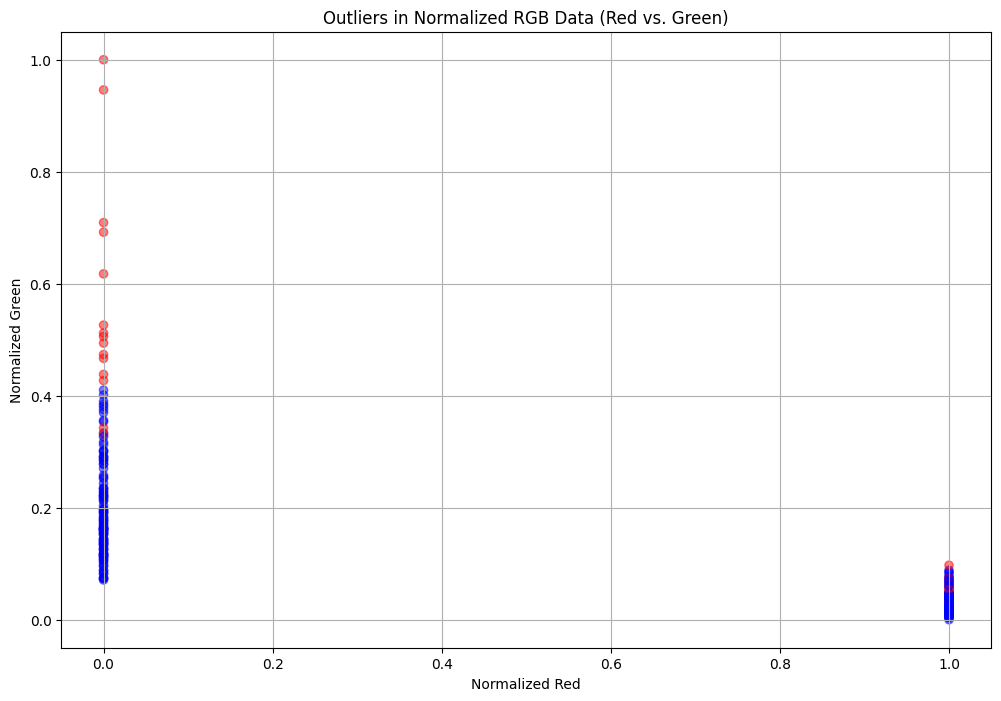

Indices of outlier data points: [  9  11  31  38  41  44  47  62  76  88  90  97 106 116 118 163 178 195
 207 216 217 218] 9.167%


In [40]:

# Set the outlier threshold
Q1 = np.percentile(dataset_normalized, 25, axis=0)
Q3 = np.percentile(dataset_normalized, 75, axis=0)
IQR = Q3 - Q1
step = 1.5 * IQR

# Check for outliers
outliers = (dataset_normalized < (Q1 - step)) | (dataset_normalized > (Q3 + step))
outliers_row = np.any(outliers, axis=1)
outlier_indices = np.where(outliers_row)

# Calculate the percentage of outliers
outlier_count = np.sum(outliers_row)
total_points = dataset_normalized.shape[0]
outlier_percentage = f'{round((outlier_count / total_points) * 100, 3)}%'

# Plot the results
plt.figure(figsize=(12, 8))
colors = ['red' if i in outlier_indices[0] else 'blue' for i in range(dataset_normalized.shape[0])]
plt.scatter(dataset_normalized[:, 0], dataset_normalized[:, 1], c=colors, alpha=0.5)
plt.xlabel('Normalized Red')
plt.ylabel('Normalized Green')
plt.title('Outliers in Normalized RGB Data (Red vs. Green)')
plt.grid(True)
plt.show()

# Print indices of outliers
print("Indices of outlier data points:", outlier_indices[0], outlier_percentage)


# Modeling Random Forest

In [41]:
# Clean dataset from outliers
dataset_cleaned = dataset[~outliers_row]

# Set the outlier threshold for 3 bands
# features = dataset[['B2', 'B3', 'B4']]
# label = dataset['class']

# Set the outlier threshold for 6 bands
features = dataset[['B2', 'B3', 'B4', 'B5', 'B6', 'B7']]
label = dataset['class']

# features = dataset_cleaned[['B2', 'B3', 'B4']]
# label = dataset_cleaned['class']

X_train, X_test, y_train, y_test = train_test_split(
    features, label, test_size=0.2, random_state=42
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Model Accuracy
print("Accuracy:", sk.metrics.accuracy_score(y_test, y_pred))

# Model Precision
print("Prectats import hmeanision:", sk.metrics.precision_score(y_test, y_pred, average='macro'))

# Model Recall
print("Recall:", sk.metrics.recall_score(y_test, y_pred, average='macro'))

# Model F1 Score
print("F1 Score:", sk.metrics.f1_score(y_test, y_pred, average='macro'))

Accuracy: 1.0
Prectats import hmeanision: 1.0
Recall: 1.0
F1 Score: 1.0


## Cofunsion Matrix

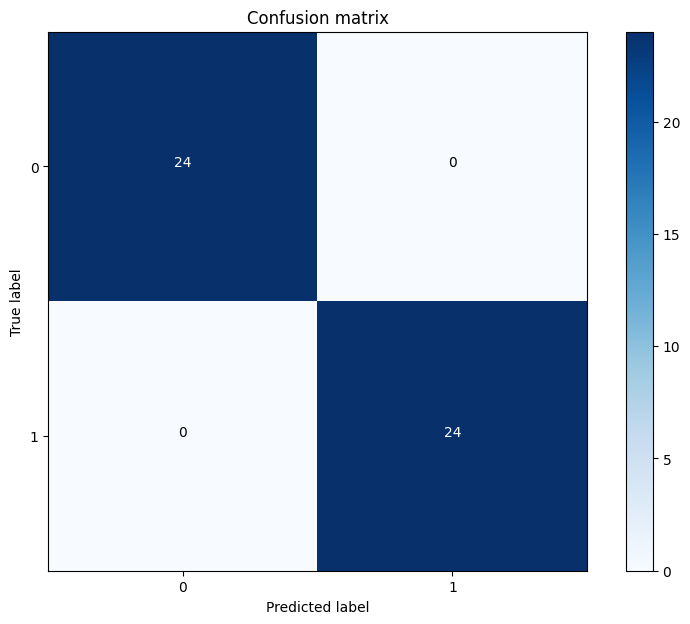

In [42]:
from matplotlib import pyplot as plt

disp = sk.metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(10, 7))
plt.imshow(disp, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()


classes = [0, 1] 
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(disp.shape[0]):
    for j in range(disp.shape[1]):
        plt.text(j, i, disp[i, j],
                 horizontalalignment="center",
                 color="white" if disp[i, j] > disp.max() / 2. else "black")


plt.show()